In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
from einops import rearrange
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffuse.diffusion_utilities import *
from diffuse.models.context_unet import ContextUnet
import os
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from diffuse.noise_scheduler import NoiseScheduler
from diffuse.utils import pil_image_grid
from PIL import Image
from diffuse.diffusion_utilities import unorm
from einops import rearrange
%load_ext autoreload
%autoreload 2


# Setting Things Up

In [2]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [3]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [4]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Training

In [5]:
# load dataset and construct optimizer
dataset = CustomDataset("../data/sprites_1788_16x16.npy", "../data/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [6]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [34]:
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:17<00:00, 50.56it/s]


saved model at ./weights/model_0.pth
epoch 1


 16%|████████████████████████████████▏                                                                                                                                                                           | 141/894 [00:02<00:11, 65.51it/s]

KeyboardInterrupt



# Sampling

In [35]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [36]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=32):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#### View Epoch 0 

In [37]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_0.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


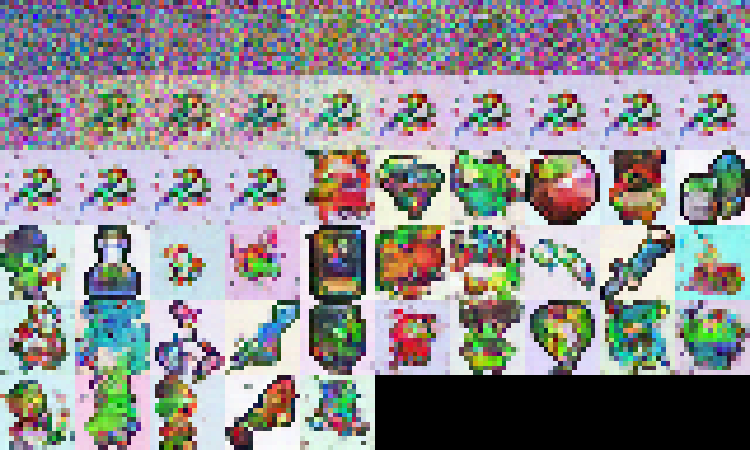

In [39]:
samples, intermediate_ddpm = sample_ddpm(32)
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z = unorm(z)
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))

#### View Epoch 4 

In [31]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_4.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


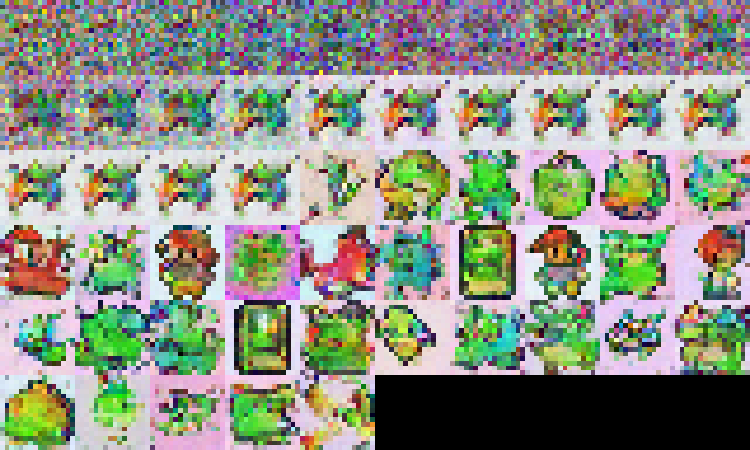

In [32]:
samples, intermediate_ddpm = sample_ddpm(32)
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z = unorm(z)
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))

#### View Epoch 8

In [29]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_8.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


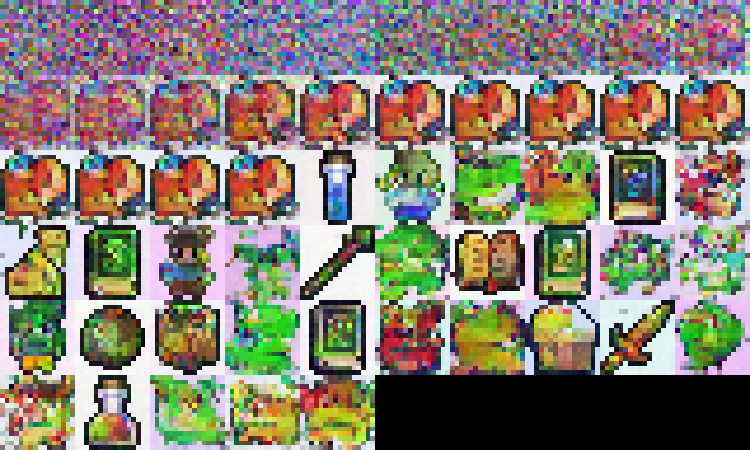

In [30]:
samples, intermediate_ddpm = sample_ddpm(32)
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z = unorm(z)
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))

#### View Epoch 31 

In [9]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_31.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


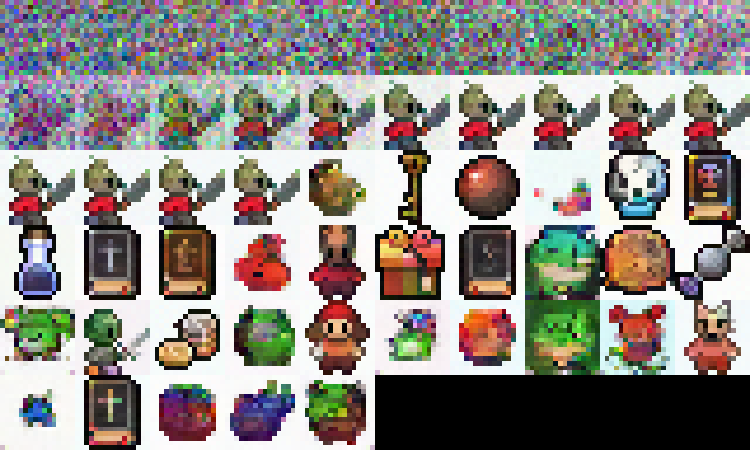

In [27]:
samples, intermediate_ddpm = sample_ddpm(32)
z = rearrange(intermediate_ddpm,'t b c h w -> b t h w c')
z = unorm(z)
pil_image_grid(np.concatenate([z[0,],z[:,-1]]), 10, (75,75))